# SVRG and SAGA Algorithms

Our goal is to minimize a convex function $f : \mathbb{R}^p \to \mathbb{R}$ of the form
$$ f: \theta \to \sum_{i=1}^n f_i(\theta) $$
where $f_1, \ldots, f_n : \mathbb{R}^p \to \mathbb{R}$ are smooth convex functions. In Machine Learning, such functions appear all the time with $f_i(\theta)$ being the loss of the $i$-th datum for parameter $\theta$.

In the previous Jupyter notebook, we used Stochastic Gradient Descent to efficiently solve this minimization program. The problem we faced was the high variance of the gradients: although $\nabla f_i(\theta)$ is an unbiased estimator of $\nabla f(\theta)$ when datum $i$ is chosen uniformly at random, its variance can be quite high. This motivated several work to find (un)biased estimators of the gradient with reduced variance. In this class, we will focus on two such algorithms: SVRG and SAGA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. SVRG: Stochastic Variance Reduced Gradient

### The Intuition behind SVRG

The idea is to reuse the basic SGD iteration, but with a modified version of the gradient. At each iteration $k$, we will pick a datum $i$ at random, compute the gradient for datum $i$ ($\nabla f_i(\theta_k)$), and modify this gradient by a zero-mean vector $- \nabla f_i(\hat\theta) + \nabla f(\hat\theta)$ where $\hat\theta$ is a previously computed point.

In other words, SVRG "remembers" a full gradient from the past $\nabla f(\hat\theta)$ and uses this information to reduce the variance of $\nabla f_i(\theta_k)$.

The iterations write:
* Initialize $\hat\theta$ at random
* Do until convergence:
    * Compute full gradient at $\hat\theta$: $\nabla f(\hat\theta)$
    * Put $\theta_0 = \hat\theta$
    * For $k$ between $1$ and $K$:
        * Choose $i \in [1 ; n]$ uniformly at random
        * $\theta_{k+1} = \theta_k - \gamma \left[ \nabla f_i(\theta_k) - \nabla f_i(\hat\theta) + \nabla f(\hat\theta) \right]$
    * Put $\hat\theta = \frac{1}{K} \theta_k$
    
__Choice of step-size $\gamma$:__ Can be taken constant and quite large.

### A first example: least squares

Let $X \in \mathbb{R}^{n \times p}$ and $y \in \mathbb{R}^n$. We wish to minimize the function
$$f(\theta) = \frac{1}{2}\|y - X\theta\|^2.$$

Here, we suppose that the observations $y$ were obtained by linear combination of data $X$, plus some noise $\sigma \xi$:
$$ y = X w + \sigma \xi $$
with $\sigma > 0$ noise level and $\xi \sim \mathcal{N}(0,I)$.

We know that the minimum of $f$ is attained at
$$\theta^* = (X^T X)^{-1} X^T y$$

In [2]:
# Definition of the data
n, p = 10, 5

X = np.random.randn(n,p)
w = np.random.randn(p)

sigma = 1.
xi = np.random.randn(n)

y = X.dot(w) + sigma*xi

In [3]:
# Definition of function f and its gradient
def f(theta):
    '''Return the least squares error at point `theta`.'''
    return 0.5 * np.linalg.norm(y - X.dot(theta))**2

def full_grad_f(theta):
    '''Return the full gradient of least squares error at point `theta`.'''
    return - X.T.dot(y - X.dot(theta))

def grad_f(theta, i):
    '''Return the gradient of least squares error at point `theta` for datum `i`.'''
    return - X[i]*(y[i] - X[i].dot(theta))

In [4]:
# Minimum of f
theta_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print('The minimum value of function `f` is =', f(theta_star))
print('It is attained at point theta^* =', theta_star)

The minimum value of function `f` is = 2.3807595777009714
It is attained at point theta^* = [-1.95054865 -0.51120106  1.57289934 -2.36764934 -0.70467732]


In [5]:
# Number of iterations to be run
max_iter = 100
max_iter_inner = 2*n

# Lists to save the sequences theta_hat, f(theta_hat), theta
theta_hat_history = []
f_history = []
theta_history = np.zeros((max_iter_inner, p))

# Step size
step_size = 0.005

# Random initial point
theta_hat = np.random.randn(p)

# SVRG Iterations
for t in range(max_iter):
    
    full_gradient_hat = full_grad_f(theta_hat)
    theta = theta_hat
    for k in range(max_iter_inner):
        i = np.random.randint(0, n)
        theta = # TODO
        theta_history[k,:] = theta
    
    theta_hat = np.mean(theta_history, axis=0)
    
    theta_hat_history.append(theta_hat)
    f_history.append(f(theta_hat))

We can vizualize the convergence of SVRG in terms of:
* The sequence $f(\theta_k) - f(\theta^*) \rightarrow 0$
* The sequence $\theta_k \rightarrow \theta^*$

We will compare with the SGD approach.

In [6]:
# SGD
max_iter = 200*n

# Lists to save the sequences theta, f(theta), theta_averaged, f(theta_averaged)
theta_SGD_history = []
f_SGD_history = []
theta_averaged_history = []
f_averaged_history = []

# Step size
L = np.linalg.norm(X.T.dot(X), ord=2)
step_size = 1. / L

# Random initial point
theta = np.random.randn(p)
theta_averaged = np.random.randn(p)

# Gradient Descent Iterations
for t in range(max_iter):
    i = np.random.randint(0, n)
    
    theta = theta - step_size * grad_f(theta, i)
    theta_averaged = (t*theta_averaged + theta)/(t+1)
    
    if t%(2*n) == 0:
        theta_SGD_history.append(theta)
        f_SGD_history.append(f(theta))
        theta_averaged_history.append(theta_averaged)
        f_averaged_history.append(f(theta_averaged))

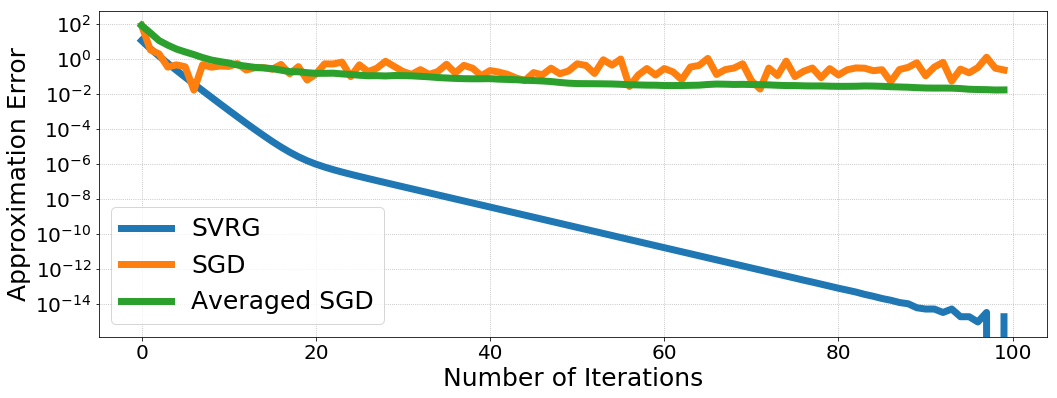

In [7]:
# Let us now plot the convergence in terms of values of `f`

plt.figure(figsize=(17,6))
plt.semilogy(f_history-f(theta_star), label='SVRG', lw=7)
plt.semilogy(f_SGD_history-f(theta_star), label='SGD', lw=7)
plt.semilogy(f_averaged_history-f(theta_star), label='Averaged SGD', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

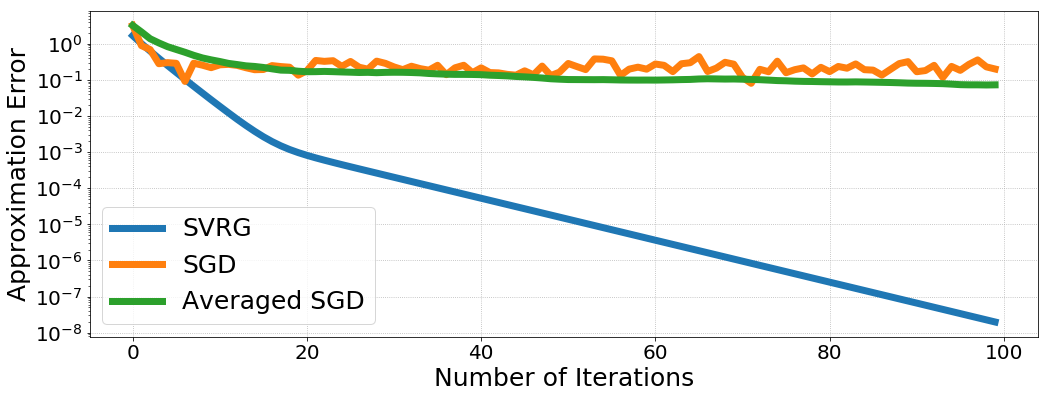

In [8]:
# Let us now plot the convergence in terms of the norm of `theta`

plt.figure(figsize=(17,6))
plt.semilogy([np.linalg.norm(theta - theta_star) for theta in theta_hat_history], label='SVRG', lw=7)
plt.semilogy([np.linalg.norm(theta - theta_star) for theta in theta_SGD_history], label='SGD', lw=7)
plt.semilogy([np.linalg.norm(theta - theta_star) for theta in theta_averaged_history], label='Averaged SGD', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

### A second example: logistic regression

We have data $x_1, \ldots, x_n \in \mathbb{R}^n$ that belong to one of the two classes $1$ or $-1$, and we write $y_i$ th class of datum $x_i$. We suppose that we observe noisy clusters that are originally linearly separable, i.e.
$$ y_i = \text{sign} \left( w^T x_i + \sigma \xi_i \right) $$
where $\sigma > 0$ is the noise level and $\xi_1, \ldots, \xi_n \sim \mathcal{N}(0,1)$ are i.i.d.

We want to learn a logistic regressor on this data, i.e. we want to find $\theta^* \in \mathbb{R}^p$ minimizing
$$ f(\theta) = \frac{1}{n}\sum_{i=1}^n \log\left( 1 + e^{-y_i \theta^T x_i} \right) $$

In [9]:
# Definition of the data
n, p = 100, 5

X = np.random.randn(n, p)
w = np.random.randn(p)

sigma = 1
xi = np.random.randn(n)

y = np.sign(X.dot(w) + sigma*xi)

In [10]:
def f(theta):
    '''Return the logistic loss for parameters `theta`.'''
    return np.mean(np.log(1.0 + np.exp(-y*X.dot(theta))))

def full_grad_f(theta):
    '''Return the full gradient of the logistic loss `f` at point `theta`.'''
    return (1./n)*(-y/(1 + np.exp(y * X.dot(theta)))).dot(X)

def grad_f(theta, i):
    '''Return the gradient of the logistic loss `f` at point `theta` for datum `i`.'''
    return (1./n)*(-y[i]/(1 + np.exp(y[i] * X[i].dot(theta))))*X[i]

In [11]:
# Number of iterations to be run
max_iter = 100
max_iter_inner = 2*n

# Lists to save the sequences theta_hat, f(theta_hat), theta
theta_hat_history = []
f_history = []
theta_history = np.zeros((max_iter_inner, p))

# Step size
step_size = 0.05

# Random initial point
theta_hat = np.random.randn(p)

# SVRG Iterations
for t in range(max_iter):
    
    full_gradient_hat = full_grad_f(theta_hat)
    theta = theta_hat
    for k in range(max_iter_inner):
        i = np.random.randint(0, n)
        theta = # TODO
        theta_history[k,:] = theta
    
    theta_hat = np.mean(theta_history, axis=0)
    
    theta_hat_history.append(theta_hat)
    f_history.append(f(theta_hat))

In [12]:
# Number of iterations to be run
max_iter = 200*n

# Lists to save the sequences theta, f(theta), theta_averaged, f(theta_averaged)
theta_SGD_history = []
f_SGD_history = []
theta_averaged_history = []
f_averaged_history = []

# Step size
L = np.linalg.norm((1./n)*X.T.dot(X), ord=2)
step_size = 1./L

# Random initial point
theta = np.random.randn(p)

# Gradient Descent Iterations
for t in range(max_iter):
    i = np.random.randint(0, n)
    
    theta = theta - step_size * grad_f(theta, i)
    theta_averaged = (t*theta_averaged + theta)/(t+1)
    
    if t%(2*n) == 0:
        theta_SGD_history.append(theta)
        f_SGD_history.append(f(theta))
        theta_averaged_history.append(theta_averaged)
        f_averaged_history.append(f(theta_averaged))

In [13]:
# Define the approximative minimum value of `f`
min_f = np.min([np.min(f_history), np.min(f_SGD_history), np.min(f_averaged_history)])

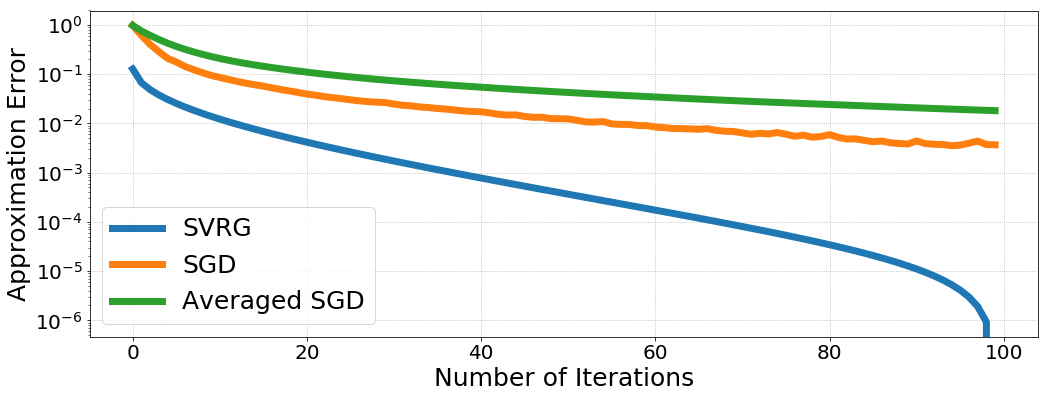

In [14]:
# Let us now plot the convergence in terms of values of `f`

plt.figure(figsize=(17,6))
plt.semilogy(f_history-min_f, label='SVRG', lw=7)
plt.semilogy(f_SGD_history-min_f, label='SGD', lw=7)
plt.semilogy(f_averaged_history-min_f, label='Averaged SGD', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

## 2. SAGA: Stochastic Average Gradient Augmented

### The Intuition behind SAGA

As in SVRG, SAGA will "remember" the past. But instead of fixing the past to be at a point $\hat\theta$, we here choose the reuse the last computed gradient.

More precisely, instead of modifying the gradient with $- \nabla f_i (\hat \theta) + \nabla f(\hat\theta)$, we modify it with $- \nabla f_i (\hat \theta_i) + \frac{1}{n} \sum_{j=1}^n \nabla f_j (\hat \theta_j)$ where $\hat\theta_j$ is the last computed gradient for datum $j$. If datum $j$ has not been used yet, we can simply put $\nabla f_j(\hat\theta_j) = 0$.

The iterations write:
* Initialize $\theta_0$ at random, put $\hat g_1 = \ldots = \hat g_n = 0$ and $\bar g = 0$
* For $k$ between $0$ and $K-1$:
    * Choose $i \in [1 ; n]$ uniformly at random
    * Compute and store gradient at $\theta_k$ for datum `i`: $g_i = \nabla f_i(\theta_k)$
    * Compute `SAGA`gradient: $G = g_i - \hat g_i + \bar g$
    * $\theta_{k+1} = \theta_k - \gamma G$
    * Update mean gradient: $\bar g = \bar g + \frac{1}{n} \left( g_i - \hat g_i \right)$
    * Update stored gradients: $\hat g_i = g_i$
    
__Choice of step-size $\gamma$:__ Can be taken constant equal to $\frac{1}{3L}$ where $L$ is the smothness constant of the $f_i$'s.

### A first example: least squares

Let $X \in \mathbb{R}^{n \times p}$ and $y \in \mathbb{R}^n$. We wish to minimize the function
$$f(\theta) = \frac{1}{2}\|y - X\theta\|^2.$$

Here, we suppose that the observations $y$ were obtained by linear combination of data $X$, plus some noise $\sigma \xi$:
$$ y = X w + \sigma \xi $$
with $\sigma > 0$ noise level and $\xi \sim \mathcal{N}(0,I)$.

We know that the minimum of $f$ is attained at
$$\theta^* = (X^T X)^{-1} X^T y$$

In [15]:
# Definition of the data
n, p = 10, 5

X = np.random.randn(n,p)
w = np.random.randn(p)

sigma = 1.
xi = np.random.randn(n)

y = X.dot(w) + sigma*xi

In [16]:
# Definition of function f and its gradient
def f(theta):
    '''Return the least squares error at point `theta`.'''
    return 0.5 * np.linalg.norm(y - X.dot(theta))**2

def full_grad_f(theta):
    '''Return the full gradient of least squares error at point `theta`.'''
    return - X.T.dot(y - X.dot(theta))

def grad_f(theta, i):
    '''Return the gradient of least squares error at point `theta` for datum `i`.'''
    return - X[i]*(y[i] - X[i].dot(theta))

In [17]:
# Minimum of f
theta_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print('The minimum value of function `f` is =', f(theta_star))
print('It is attained at point theta^* =', theta_star)

The minimum value of function `f` is = 3.2286158837880405
It is attained at point theta^* = [ 1.14382599 -0.95776565 -0.28574612  1.96890141 -0.3603342 ]


In [18]:
# Number of iterations to be run
max_iter = 200*n

# Lists to save the sequences theta_hat, f(theta_hat), theta
theta_SAGA_history = []
f_history = []

# Stores the gradients and the mean gradient
gradients = np.zeros((n,p))
mean_gradient = np.zeros(p)

# Step size
L = np.linalg.norm(X.T.dot(X), ord=2)
step_size = 1. / (3*L)

# Random initial point
theta = np.random.randn(p)

# SAGA Iterations
for t in range(max_iter):
    i = np.random.randint(0, n)
    
    # Computation of Gradients
    gradient_i = # TODO
    G = # TODO
    
    # Gradient Step
    theta = # TODO
    if t%(2*n) == 0:
        theta_SAGA_history.append(theta)
        f_history.append(f(theta))
    
    # Storage
    mean_gradient += # TODO
    gradients[i] = # TODO

We can vizualize the convergence of SAGA in terms of:
* The sequence $f(\theta_k) - f(\theta^*) \rightarrow 0$
* The sequence $\theta_k \rightarrow \theta^*$

We will compare with the SVRG approach.

In [19]:
# SVRG
max_iter = 100
max_iter_inner = 2*n

# Lists to save the sequences theta_hat, f(theta_hat), theta
theta_hat_history = []
f_SVRG_history = []
theta_history = np.zeros((max_iter_inner, p))

# Step size
step_size = 0.005

# Random initial point
theta_hat = np.random.randn(p)

# SVRG Iterations
for t in range(max_iter):
    
    full_gradient_hat = full_grad_f(theta_hat)
    theta = theta_hat
    for k in range(max_iter_inner):
        i = np.random.randint(0, n)
        theta = # TODO
        theta_history[k,:] = theta
    
    theta_hat = np.mean(theta_history, axis=0)
    
    theta_hat_history.append(theta_hat)
    f_SVRG_history.append(f(theta_hat))

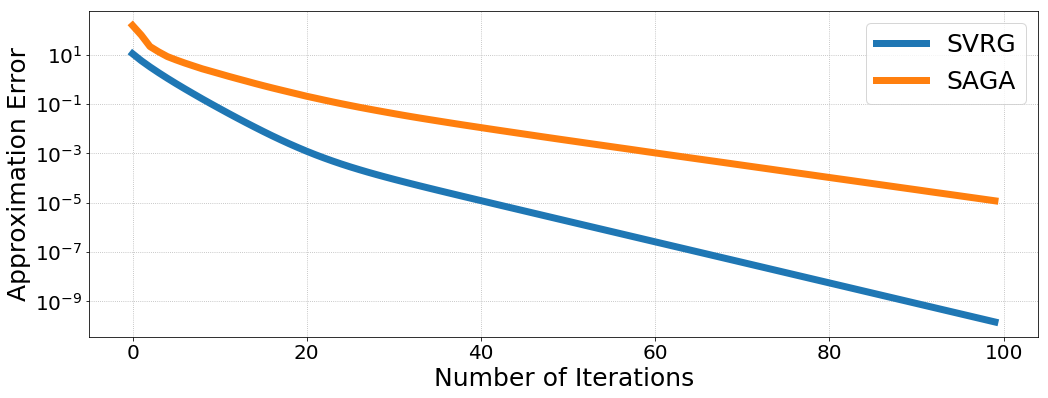

In [20]:
# Let us now plot the convergence in terms of values of `f`

plt.figure(figsize=(17,6))
plt.semilogy(f_SVRG_history-f(theta_star), label='SVRG', lw=7)
plt.semilogy(f_history-f(theta_star), label='SAGA', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

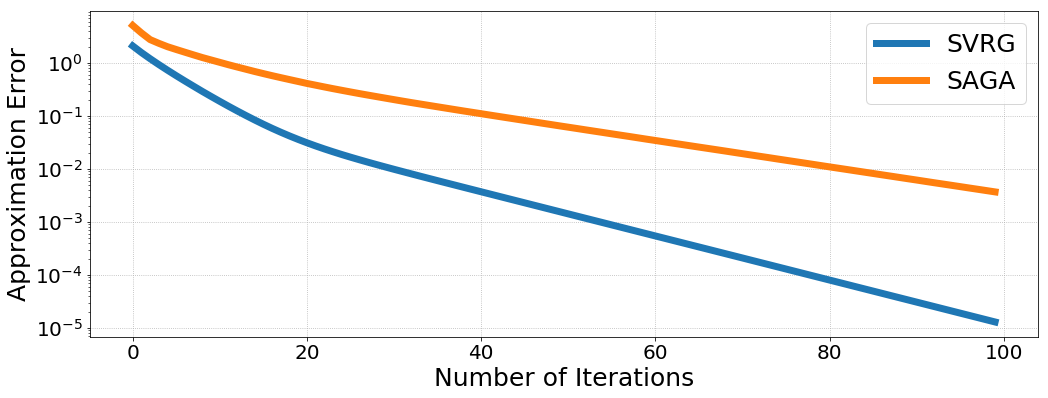

In [21]:
# Let us now plot the convergence in terms of the norm of `theta`

plt.figure(figsize=(17,6))
plt.semilogy([np.linalg.norm(theta - theta_star) for theta in theta_hat_history], label='SVRG', lw=7)
plt.semilogy([np.linalg.norm(theta - theta_star) for theta in theta_SAGA_history], label='SAGA', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

### A second example: logistic regression

We have data $x_1, \ldots, x_n \in \mathbb{R}^n$ that belong to one of the two classes $1$ or $-1$, and we write $y_i$ th class of datum $x_i$. We suppose that we observe noisy clusters that are originally linearly separable, i.e.
$$ y_i = \text{sign} \left( w^T x_i + \sigma \xi_i \right) $$
where $\sigma > 0$ is the noise level and $\xi_1, \ldots, \xi_n \sim \mathcal{N}(0,1)$ are i.i.d.

We want to learn a logistic regressor on this data, i.e. we want to find $\theta^* \in \mathbb{R}^p$ minimizing
$$ f(\theta) = \frac{1}{n}\sum_{i=1}^n \log\left( 1 + e^{-y_i \theta^T x_i} \right) $$

In [22]:
# Definition of the data
n, p = 100, 5

X = np.random.randn(n, p)
w = np.random.randn(p)

sigma = 1
xi = np.random.randn(n)

y = np.sign(X.dot(w) + sigma*xi)

In [23]:
def f(theta):
    '''Return the logistic loss for parameters `theta`.'''
    return np.mean(np.log(1.0 + np.exp(-y*X.dot(theta))))

def full_grad_f(theta):
    '''Return the full gradient of the logistic loss `f` at point `theta`.'''
    return (1./n)*(-y/(1 + np.exp(y * X.dot(theta)))).dot(X)

def grad_f(theta, i):
    '''Return the gradient of the logistic loss `f` at point `theta` for datum `i`.'''
    return (1./n)*(-y[i]/(1 + np.exp(y[i] * X[i].dot(theta))))*X[i]

In [24]:
# Number of iterations to be run
max_iter = 200*n

# Lists to save the sequences theta_hat, f(theta_hat), theta
theta_history = []
f_history = []

# Stores the gradients and the mean gradient
gradients = np.zeros((n,p))
mean_gradient = np.zeros(p)

# Step size
L = np.linalg.norm((1./n)*X.T.dot(X), ord=2)
step_size = 1. / (3*L)

# Random initial point
theta = np.random.randn(p)

# SAGA Iterations
for t in range(max_iter):
    i = np.random.randint(0, n)
    
    # Computation of Gradients
    gradient_i = # TODO
    G = # TODO
    
    # Gradient Step
    theta = # TODO
    if t%(2*n) == 0:
        theta_history.append(theta)
        f_history.append(f(theta))
    
    # Storage
    mean_gradient += (1./n) * (gradient_i - gradients[i])
    gradients[i] = gradient_i

In [25]:
# SVRG
max_iter = 100
max_iter_inner = 2*n

# Lists to save the sequences theta_hat, f(theta_hat), theta
f_SVRG_history = []
theta_history = np.zeros((max_iter_inner, p))

# Step size
step_size = 0.005

# Random initial point
theta_hat = np.random.randn(p)

# SVRG Iterations
for t in range(max_iter):
    
    full_gradient_hat = full_grad_f(theta_hat)
    theta = theta_hat
    for k in range(max_iter_inner):
        i = np.random.randint(0, n)
        theta = theta - step_size * ( grad_f(theta, i)  - grad_f(theta_hat, i) + full_gradient_hat )
        theta_history[k,:] = theta
    
    theta_hat = np.mean(theta_history, axis=0)
    f_SVRG_history.append(f(theta_hat))

In [26]:
# Define the approximative minimum value of `f`
min_f = np.min([np.min(f_history), np.min(f_SVRG_history)])

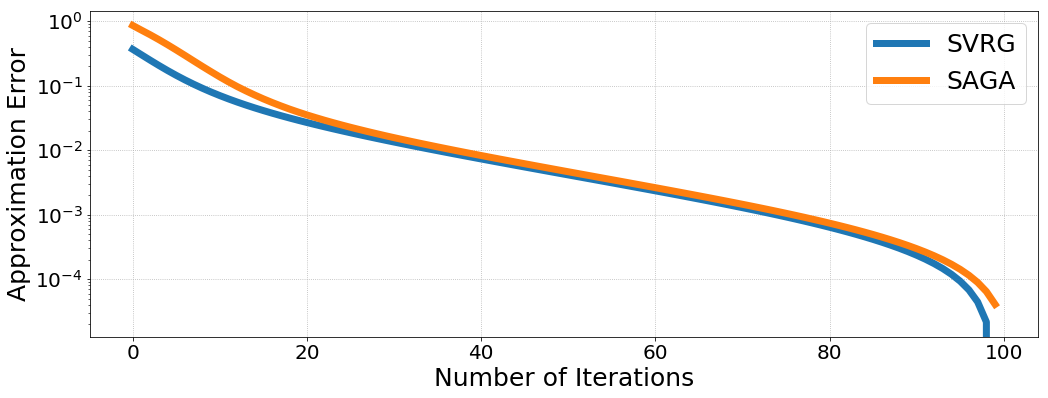

In [27]:
# Let us now plot the convergence in terms of values of `f`

plt.figure(figsize=(17,6))
plt.semilogy(f_SVRG_history-min_f, label='SVRG', lw=7)
plt.semilogy(f_history-min_f, label='SAGA', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()